# Condition-specific mode 
### Run Splitpea on differential splicing outputs

Examples to show how to use Splitpea package with differential splicing outputs from both rMATS and SUPPA2.


In [ ]:
%%capture
# install necessary dependencies (this can take a few minutes)
%pip install splitpea
%pip install gseapy  # needed for enrichment functionality

# additional mapping file for organism id conversions
!wget https://raw.githubusercontent.com/ylaboratory/splitpea/master/reference/hsa_mapping_all.txt

# Tabix is used under-the-hood for some of the functions and should be installed before running
# install directly via the command line or with conda
#!sudo apt-get install tabix
%conda install -y -c bioconda tabix

In [1]:
import splitpea
import pandas as pd
import gseapy as gp

## rMATS example


In this example, we use the rMATS-turbo example data for prostate cancer cell lines stored [here](https://zenodo.org/records/6647024). You can read more about the dataset in the [rMATS-turbo manuscript](https://pubmed.ncbi.nlm.nih.gov/38396040/).

For simplicity, we include the shell commands for downloading and extracting these necessary files below. You can also alternatively also download and extract these files yourself.

In [17]:
!wget -O PC3E-GS689.tar https://zenodo.org/records/6647024/files/PC3E-GS689.tar.gz?download=1
!tar -xvzf PC3E-GS689.tar

--2025-09-10 01:55:52--  https://zenodo.org/records/6647024/files/PC3E-GS689.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119609490 (114M) [application/octet-stream]
Saving to: ‘PC3E-GS689.tar’

PC3E-GS689.tar       28%[====>               ]  32.41M  2.92MB/s    eta 37s    ^C
PC3E-GS689/
PC3E-GS689/fromGTF.novelJunction.SE.txt
PC3E-GS689/fromGTF.novelSpliceSite.A5SS.txt
PC3E-GS689/SE.MATS.JC.txt
PC3E-GS689/RI.MATS.JCEC.txt
PC3E-GS689/JCEC.raw.input.RI.txt
PC3E-GS689/fromGTF.novelSpliceSite.MXE.txt
PC3E-GS689/fromGTF.RI.txt
PC3E-GS689/JC.raw.input.RI.txt
PC3E-GS689/summary.txt
PC3E-GS689/fromGTF.novelJunction.RI.txt
PC3E-GS689/A3SS.MATS.JCEC.txt
PC3E-GS689/fromGTF.novelSpliceSite.SE.txt
PC3E-GS689/JC.raw.input.SE.txt


rMATS produces two alternative splicing event files for skipped exons (SE), one containing both junction reads and those spanning the exon body (`SE.MATS.JCEC.txt`) and one counting only junction reads (`SE.MATS.JC.txt`). Either SE file can be used as input to Splitpea, but in our example we will use the `JCEC.txt` file.


#### Running Splitpea

To run Splitpea, call the `splitpea.run` function with three key arguments:  
1. the rMATS splicing output file as input,  
2. `differential_format="rmats"` to specify the file type, and  
3. an output prefix.  

You can also customize the run by adjusting additional parameters, such as modifying PSI and p-value filters or providing your own alternative reference files in place of the defaults. For a full list of options, see the package's [documentation](https://github.com/ylaboratory/splitpea_package).

This will generate two files:  
- `<out_file_prefix>.edges.dat`: a per-edge summary table  
- `<out_file_prefix>.edges.pickle`: a pickled NetworkX graph of the rewired network

In [2]:
splitpea.run(
    in_file = "PC3E-GS689/SE.MATS.JCEC.txt",
    differential_format = "rmats",
    out_file_prefix = "PC3E_GS689",
    verbose = True
)


09-19-2025 05:04:06 PM:INFO:Loading DDIs....
09-19-2025 05:04:06 PM:INFO:# pfams: 8602, # ddis: 17450
09-19-2025 05:04:06 PM:INFO:Loading PPIs....
09-19-2025 05:04:08 PM:INFO:# proteins: 20286, # interactions: 793078
09-19-2025 05:04:08 PM:INFO:Loading gene-protein domain info....
09-19-2025 05:04:08 PM:INFO:Reading differential exon results....
09-19-2025 05:04:08 PM:INFO:Reading in input exons...
09-19-2025 05:04:09 PM:INFO:# of differentially expressed exons: 20067
09-19-2025 05:04:09 PM:INFO:Calculating network....
09-19-2025 05:12:29 PM:INFO:# nodes: 6173, # edges: 17012
09-19-2025 05:12:29 PM:INFO:Outputting as pickle...
09-19-2025 05:12:30 PM:INFO:Temporary file examples/tmpiwrjtib_.txt deleted.
09-19-2025 05:12:30 PM:INFO:Done


#### Analyzing the rewired network

After generating a rewired network with `splitpea.run`, we can compute per-gene and per-edge summary statistics using the `splitpea.stats` function.  

This function takes as input the `<prefix>.edges.dat` and `<prefix>.edges.pickle` files generated by `splitpea.run`. As output, it prints the total number of gain, loss, and chaos edges in the network and returns a DataFrame for per-node analysis. Each row corresponds to a gene and includes its Entrez ID, gene symbol, degree (the number of edges connected to the gene), normalized degree (the percentage of the maximum possible rewiring relative to the reference PPI), as well as the number of gain, loss, and chaos edges that the gene is involved in. The dataframe is sorted by degree.



In [ ]:
PC3E_GS689_stats = splitpea.stats(rewired_net="PC3E_GS689.edges.pickle", dat_file="PC3E_GS689.edges.dat")
PC3E_GS689_stats

    Basic edge stats:
    Gain : 7883
    Loss : 7308
    Chaos: 1821
    


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
0,3845,KRAS,296,1.000000,271,0,25
1,2782,GNB1,275,1.000000,270,0,5
2,3320,HSP90AA1,235,0.971074,1,211,23
3,3265,HRAS,234,1.000000,0,222,12
4,5879,RAC1,197,1.000000,0,0,197
...,...,...,...,...,...,...,...
6168,9787,DLGAP5,1,0.200000,1,0,0
6169,254394,MCM9,1,0.250000,1,0,0
6170,7042,TGFB2,1,0.090909,1,0,0
6171,933,CD22,1,0.111111,0,1,0


#### Visualizing the rewired network  

You can either visualize the network directly in Python or export it for use in dedicated tools such as Gephi or Cytoscape. This particular network (> 5,000 nodes) is too large to visualize directly using the built-in `splitpea.plot` function (as noted by the warning). Generally, we recommend only visualizing small networks (< 50 nodes) directly in Python and instead exporting large networks to Gephi or Cytoscape.


To do this, you can simply pass in the `.edges.pickle` file generated by `splitpea.run` as input to `splitpea.plot`. In the example below, we export the network to both formats. To make the visualization clearer, we set `self_edges=False` (removes self-loops) and `lcc=True` (keeps only the largest connected component). These parameters are optional and can be adjusted depending on user preferences.  


In [5]:
splitpea.plot("PC3E_GS689.edges.pickle", gephi_path ="PC3E_GS689.tsv", cytoscape_path = "PC3E_GS689.gml", self_edges = False, lcc = True)

Generated outputs:
  Gephi TSV → PC3E_GS689.tsv
  Cytoscape GML → PC3E_GS689.gml


#### Example downstream analysis  

Here we demonstrate a simple downstream analysis that highlights what Splitpea can reveal beyond standard rMATS output.  

First, we examine the raw rMATS file (`SE.MATS.JCEC.txt`) to count the total number of skipped exon (SE) events, the number of unique genes involved, and how many of those events and genes are significant at *p* < 0.05.  

Next, we compare these results to the Splitpea network statistics. Specifically, we ask whether there are genes with high connectivity (degree in the top 10% of the rewired network) that were **not** detected as significant by rMATS. These genes may represent cases whose interactions might be disrupted by spicing, even if the gene itself is not strongly differentially spliced.



In [ ]:
rmats_df = pd.read_csv("PC3E-GS689/SE.MATS.JCEC.txt", sep="\t", index_col=0)

# count SE events and unique genes
print("Total number of SE events:", len(rmats_df))
print("Total number of unique genes:", rmats_df['geneSymbol'].nunique())

# significant events (FDR < 0.05)
sig_mask = rmats_df['FDR'].astype(float) < 0.05
sig_genes = rmats_df.loc[sig_mask, 'geneSymbol'].dropna().unique()

print("Number of significant SE events:", sig_mask.sum())
print("Number of unique significant genes:", len(sig_genes))

# compare with splitpea results
no_common_sig = PC3E_GS689_stats.loc[~PC3E_GS689_stats['symbol'].isin(sig_genes)].copy()
print("Number of genes in Splitpea not significant in rMATS:", len(no_common_sig))

degree_threshold = PC3E_GS689_stats['degree'].quantile(0.9)
high_degree_genes = no_common_sig[no_common_sig['degree'] >= degree_threshold]
print("Number of high-degree genes (top 10%) not significant in rMATS:", len(high_degree_genes))
high_degree_genes.head(10)


Total number of SE events: 308739
Total number of unique genes: 15094
Number of significant SE events: 17835
Number of unique significant genes: 5746
Number of genes in Splitpea not significant in rMATS: 3793
Number of high-degree genes (top 10%) not significant in rMATS: 212


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
2,3320,HSP90AA1,235,0.971074,1,211,23
21,2065,ERBB3,100,0.892857,0,92,8
22,54509,RHOF,99,1.000000,92,0,7
35,6626,SNRPA,81,1.000000,76,0,5
38,7316,UBC,74,0.192708,29,43,2
48,57664,PLEKHA4,57,0.160112,28,27,2
50,3015,H2AZ1,56,1.000000,50,0,6
52,5563,PRKAA2,55,1.000000,51,0,4
55,9555,MACROH2A1,52,1.000000,0,49,3
70,11200,CHEK2,45,0.937500,43,0,2


We can also try to analyze the broader pathway changes reflected in the rewired networks. Here we use [GSEApy](https://academic.oup.com/bioinformatics/article/39/1/btac757/6847088) for GO Biological Process gene enrichment ranking genes either by gain edge count or by loss edge count, with ties broken by normalized degree and then by raw degree.



In [5]:
def build_prerank(stats_df, count_col):
    return (
        stats_df
        .dropna(subset=["symbol", count_col, "normalized_degree", "degree"])
        .sort_values(by=[count_col, "normalized_degree", "degree"], ascending=False)
        .assign(score=lambda df: (
            df.groupby([count_col, "normalized_degree", "degree"], sort=False)
              .ngroup()
              .pipe(lambda g: g.max() - g + 1)
        ))
        .loc[:, ["symbol", "score"]]
        .rename(columns={"symbol": "gene"})
    )

def run_gsea_prerank(rnk, gene_sets="GO_Biological_Process_2023", threads=10, seed=42):
    pre = gp.prerank(rnk=rnk, gene_sets=gene_sets, threads=threads, seed=seed, verbose=False)
    sig = pre.res2d.query("`FDR q-val` < 0.05").copy()
    nes_pos = sig[sig["NES"] > 0].copy()
    return pre, sig, nes_pos

gain_rnk = build_prerank(PC3E_GS689_stats, "gain_count")
pre_gain, sig_gain, gain_results = run_gsea_prerank(gain_rnk)

loss_rnk = build_prerank(PC3E_GS689_stats, "loss_count")
pre_loss, sig_loss, loss_results = run_gsea_prerank(loss_rnk)

print("Top GO BP (gain):")
display(gain_results)

print("Top GO BP (loss):")
display(loss_results)


2025-09-19 17:19:48,352 [WARNING] Duplicated values found in preranked stats: 74.45% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-19 17:19:54,129 [WARNING] Duplicated values found in preranked stats: 74.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Top GO BP (gain):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,mRNA Stabilization (GO:0048255),0.769845,2.060759,0.0,0.0,0.0,16/30,10.76%,YBX1;MAPKAPK2;ELAVL1;CSDE1;FUS;IGF2BP3;TARDBP;...
1,prerank,Regulation Of Small GTPase Mediated Signal Tra...,0.674744,1.99588,0.0,0.001497,0.003,62/101,17.68%,RHOF;NGEF;ARHGEF9;OBSCN;SRC;ARHGEF25;VAV1;RACG...
2,prerank,U2-type Prespliceosome Assembly (GO:1903241),0.749702,1.941429,0.0,0.001663,0.005,12/22,8.64%,SNRPA1;SNRPD1;SF3B6;SNRPB2;SF3B4;SNRPG;SNRPD2;...
3,prerank,Negative Regulation Of mRNA Catabolic Process ...,0.747774,1.937125,0.0,0.001248,0.005,10/22,8.44%,YBX1;ELAVL1;CSDE1;FUS;HNRNPD;PABPC1;TAF15;IGF2...
4,prerank,Fc-gamma Receptor Signaling Pathway (GO:0038094),0.747104,1.892965,0.0,0.001397,0.006,15/17,21.42%,PTK2;SRC;PAK1;VAV1;LCK;LYN;FYN;LIMK1;PLA2G6;PR...
...,...,...,...,...,...,...,...,...,...,...
145,prerank,G1/S Transition Of Mitotic Cell Cycle (GO:0000...,0.545789,1.533015,0.002,0.049268,0.996,20/49,20.77%,CUL1;CUL4A;CDK18;CCND3;CUL3;PLK3;BRD4;CDKN1A;C...
146,prerank,Protein K63-linked Ubiquitination (GO:0070534),0.552482,1.532593,0.001,0.049176,0.996,30/41,34.15%,UBE2D4;UBE2S;PRKN;RNF5;STUB1;TRAF6;RNF167;ITCH...
147,prerank,Protein Autoubiquitination (GO:0051865),0.542112,1.532442,0.0,0.048971,0.996,36/54,33.25%,UBE2D2;RNF185;PRKN;MDM2;CUL3;RAD51;UBE2D3;RNF1...
148,prerank,Negative Regulation Of Cellular Metabolic Proc...,0.574063,1.531993,0.007007,0.048876,0.997,16/27,28.87%,YBX1;PRKN;FZR1;SREBF1;SIRT6;MAP3K3;PINK1;CDK6;...


Top GO BP (loss):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Fc-gamma Receptor Signaling Pathway (GO:0038094),0.771041,1.873039,0.0,0.003999,0.004,14/17,14.53%,YES1;SRC;LYN;LCK;FYN;VAV1;PTK2;PAK1;PRKCE;PRKC...
1,prerank,Spliceosomal snRNP Assembly (GO:0000387),0.746748,1.869275,0.0,0.002499,0.005,16/25,13.69%,LSM2;LSM4;PRPF3;PRPF8;CLNS1A;HNRNPC;PRPF19;SNR...
2,prerank,Fc-gamma Receptor Signaling Pathway Involved I...,0.764505,1.848862,0.0,0.001749,0.007,14/16,19.04%,YES1;SRC;LYN;FYN;VAV1;PTK2;PAK1;PRKCE;PRKCD;SY...
3,prerank,Fc Receptor Mediated Stimulatory Signaling Pat...,0.764505,1.848862,0.0,0.001749,0.007,14/16,19.04%,YES1;SRC;LYN;FYN;VAV1;PTK2;PAK1;PRKCE;PRKCD;SY...
4,prerank,Fc Receptor Signaling Pathway (GO:0038093),0.717403,1.783794,0.0,0.007797,0.036,18/22,20.76%,LYN;PLCG1;LCK;VAV1;MAPK8;SOS1;MAP2K7;SYK;MAPK9...
...,...,...,...,...,...,...,...,...,...,...
108,prerank,Regulation Of Rho Protein Signal Transduction ...,0.576591,1.522492,0.0,0.049585,0.983,27/50,28.87%,ARRB1;BCR;ABL1;RAF1;MET;CUL3;MYO9B;AKAP13;ARHG...
109,prerank,Positive Regulation Of Lipid Kinase Activity (...,0.608959,1.521779,0.00201,0.049643,0.984,19/25,32.96%,PDGFRB;PTK2;PRKD1;PDGFRA;IRS1;NOD2;F2;FLT1;PIK...
110,prerank,Positive Regulation Of Ubiquitin-Dependent Pro...,0.575986,1.521282,0.0,0.049519,0.984,19/50,14.45%,CSNK1D;RAD23A;RBX1;PRKN;LRRK2;FBXW7;PLK1;GSK3B...
111,prerank,Regulation Of Protein Polymerization (GO:0032271),0.64533,1.52053,0.006085,0.049667,0.984,11/16,26.69%,HSP90AA1;ABL1;CAMSAP1;RASA1;PFN2;MAPRE3;LATS1;...


## SUPPA2 example

In this example, we use data associated with the SUPP2 publication for early and late erythroblast differentiation found [here](https://github.com/comprna/SUPPA_supplementary_data). You can read more about the dataset in the [SUPPA2 manuscript](https://pubmed.ncbi.nlm.nih.gov/29571299/).

Again, for simplicity, we include the shell commands for downloading and extracting these necessary files below. You can also alternatively also download and extract these files yourself. 

SUPPA2 provides two files (`*.psivec` and `*.dpsi`) per comparison. Both files are required for using Splitpea with SUPPA2 outputs. In this analysis, we specifically use `proe_orthoe.psivec` and `proe_orthoe.dpsi` as our input files from the early and late erythroblast differentiation comparison.

In [22]:
!wget -O proe_orthoe.psivec.gz https://github.com/comprna/SUPPA_supplementary_data/raw/refs/heads/master/supplementary_data/erythro/SUPPA/proe_orthoe.psivec.gz
!wget -O proe_orthoe.dpsi.gz https://github.com/comprna/SUPPA_supplementary_data/raw/refs/heads/master/supplementary_data/erythro/SUPPA/proe_orthoe.dpsi.gz

!gunzip proe_orthoe.dpsi.gz
!gunzip proe_orthoe.psivec.gz

--2025-09-10 02:17:53--  https://github.com/comprna/SUPPA_supplementary_data/raw/refs/heads/master/supplementary_data/erythro/SUPPA/proe_orthoe.psivec.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/comprna/SUPPA_supplementary_data/refs/heads/master/supplementary_data/erythro/SUPPA/proe_orthoe.psivec.gz [following]
--2025-09-10 02:17:54--  https://raw.githubusercontent.com/comprna/SUPPA_supplementary_data/refs/heads/master/supplementary_data/erythro/SUPPA/proe_orthoe.psivec.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5573762 (5.3M) [application/octet-stream]
Saving to: ‘proe_orthoe.psi

#### Running Splitpea

To run Splitpea, call the `splitpea.run` function with three key arguments:  
1. both SUPPA2 splicing output files (order does not matter) as input,  
2. `differential_format="suppa2"` to specify the file type, and  
3. an output prefix.  

You can also customize the run by adjusting [additional parameters](https://github.com/ylaboratory/splitpea_package), such as modifying PSI and p-value filters for events to be considered or providing your own alternative reference files in place of the defaults. As before a successful run of Splitpea will generate 2 output files:  a per-edge summary table (`<out_file_prefix>.edges.dat`) and the NetworkX graph (`<out_file_prefix>.edges.pickle`).

In [4]:
splitpea.run(
    in_file = ["proe_orthoe.psivec", "proe_orthoe.dpsi"],
    differential_format="suppa2",
    out_file_prefix = "proe_orthoe",
    verbose = True
)

09-11-2025 01:51:13 AM:INFO:Loading DDIs....
09-11-2025 01:51:13 AM:INFO:# pfams: 8602, # ddis: 17450
09-11-2025 01:51:13 AM:INFO:Loading PPIs....
09-11-2025 01:51:15 AM:INFO:# proteins: 20286, # interactions: 793078
09-11-2025 01:51:15 AM:INFO:Loading gene-protein domain info....
09-11-2025 01:51:15 AM:INFO:Reading differential exon results....
09-11-2025 01:51:15 AM:INFO:Reading in input exons...
09-11-2025 01:51:15 AM:INFO:# of differentially expressed exons: 480
09-11-2025 01:51:15 AM:INFO:Calculating network....
09-11-2025 01:51:31 AM:INFO:# nodes: 1234, # edges: 1483
09-11-2025 01:51:31 AM:INFO:Outputting as pickle...
09-11-2025 01:51:31 AM:INFO:Temporary file tmpf68su5j8.txt deleted.
09-11-2025 01:51:31 AM:INFO:Done


#### Analyzing the rewired network

As before, we can now compute per-gene and per-edge summary statistics using `splitpea.stats`, which takes the two output files generated by `splitpea.run`. 

In [ ]:
proe_orthoe_stats = splitpea.stats(dat_file="proe_orthoe.edges.dat", rewired_net="proe_orthoe.edges.pickle")
proe_orthoe_stats

    Basic edge stats:
    Gain : 836
    Loss : 629
    Chaos: 18
    


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
0,3845,KRAS,296,1.000000,295,0,1
1,6733,SRPK2,142,1.000000,141,0,1
2,7334,UBE2N,98,1.000000,98,0,0
3,4670,HNRNPM,91,0.978495,0,90,1
4,3093,UBE2K,66,0.929577,0,65,1
...,...,...,...,...,...,...,...
1229,23271,CAMSAP2,1,0.045455,1,0,0
1230,22919,MAPRE1,1,0.018182,1,0,0
1231,22924,MAPRE3,1,0.031250,1,0,0
1232,5829,PXN,1,0.021277,1,0,0


#### Visualizing the Splitpea network  

Since this network is significantly smaller we visualize directly with the `splitpea.plot` function and save the output to a pdf file. To make the visualization clearer, we removed self loops (`self_edges=False`) and plot only the largest connected component (`lcc=True`).  

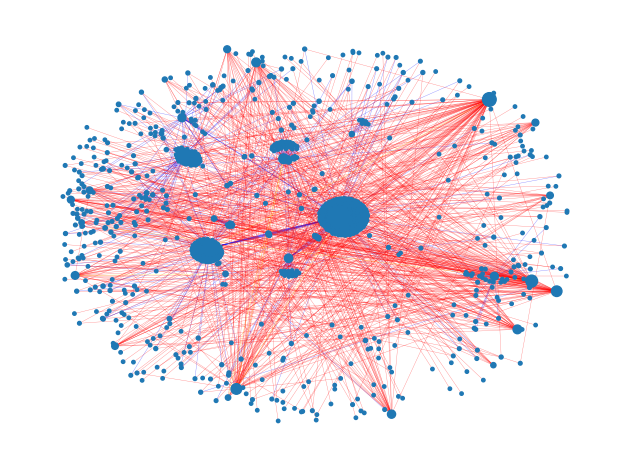

Generated outputs:
  PDF → proe_orthoe.pdf


In [ ]:
splitpea.plot("proe_orthoe.edges.pickle", pdf_path ="proe_orthoe.pdf", self_edges = False, lcc = True)

#### Example downstream analysis  

Once again, we compare our findings with the differentially skipped exon events identified with SUPPA2. Specifically, we ask whether there are genes with high connectivity (degree in the top 10% of the rewired network) that were **not** detected as significant by SUPPA2. These genes may represent cases whose interactions might be disrupted by spicing, even if the gene itself is not strongly differentially spliced.

In [8]:
map_file = "hsa_mapping_all.txt" # gene mapping file (downloaded in the dependencies section)

# load SUPPA2 results and filter to SE events only
dpsi_df = pd.read_csv("proe_orthoe.dpsi", sep="\t", index_col=0)
event_type = dpsi_df.index.to_series().str.extract(r';([^:]+):', expand=False)
dpsi_df = dpsi_df[event_type.eq("SE")].copy()

# map Ensembl gene IDs to gene symbols to match splitpea
dpsi_df["ensembl"] = dpsi_df.index.str.split(";").str[0].str.split(".").str[0]
map_df = pd.read_csv(map_file, sep="\t", dtype=str)
ens2sym = (map_df[["ensembl", "symbol"]]
           .drop_duplicates("ensembl")
           .set_index("ensembl")["symbol"])
dpsi_df["symbol"] = dpsi_df["ensembl"].map(ens2sym)

print("Total number of SE events in SUPPA2:", len(dpsi_df))
print("Total number of unique genes in SUPPA2:", dpsi_df["symbol"].dropna().nunique())

# limit to significant events (p < 0.05)
sig_mask = dpsi_df["proe-orthoe_p-val"].astype(float) < 0.05
sig_genes_suppa = dpsi_df.loc[sig_mask, "symbol"].dropna().unique()

print("Number of significant SE events in SUPPA2:", sig_mask.sum())
print("Number of unique significant genes in SUPPA2:", len(sig_genes_suppa))

# compare with Splitpea 
no_common_sig = proe_orthoe_stats.loc[~proe_orthoe_stats["symbol"].isin(sig_genes_suppa)].copy()
print("Number of genes in Splitpea not significant in SUPPA2:", len(no_common_sig))

degree_threshold = proe_orthoe_stats["degree"].quantile(0.9)
high_degree_genes_2 = no_common_sig[no_common_sig["degree"] >= degree_threshold]
print("Number of high-degree genes (top 10%) not significant in SUPPA2:", len(high_degree_genes_2))

high_degree_genes_2.head(10)


Total number of SE events in SUPPA2: 37432
Total number of unique genes in SUPPA2: 11313
Number of significant SE events in SUPPA2: 481
Number of unique significant genes in SUPPA2: 374
Number of genes in Splitpea not significant in SUPPA2: 1103
Number of high-degree genes (top 10%) not significant in SUPPA2: 48


,node,symbol,degree,normalized_degree,gain_count,loss_count,chaos_count
36,8031,NCOA4,6,1.000000,0,6,0
52,5071,PRKN,5,0.029940,2,3,0
53,7316,UBC,5,0.013021,2,3,0
59,9939,RBM8A,4,0.060606,2,2,0
60,9212,AURKB,4,0.027586,2,2,0
64,7314,UBB,4,0.019608,2,2,0
67,4914,NTRK1,4,0.017699,2,2,0
71,8726,EED,4,0.074074,3,1,0
74,3178,HNRNPA1,3,0.019355,1,2,0
75,3183,HNRNPC,3,0.027027,1,2,0


Now once again we run GSEA ranking genes by gain edge count or by loss edge count, with ties broken by normalized degree and then by raw degree to find enriched GO biological processes. 



In [9]:
def build_prerank(stats_df, count_col):
    return (
        stats_df
        .dropna(subset=["symbol", count_col, "normalized_degree", "degree"])
        .sort_values(by=[count_col, "normalized_degree", "degree"], ascending=False)
        .assign(score=lambda df: (
            df.groupby([count_col, "normalized_degree", "degree"], sort=False)
              .ngroup()
              .pipe(lambda g: g.max() - g + 1)
        ))
        .loc[:, ["symbol", "score"]]
        .rename(columns={"symbol": "gene"})
    )

def run_gsea_prerank(rnk, gene_sets="GO_Biological_Process_2023", threads=10, seed=42):
    pre = gp.prerank(rnk=rnk, gene_sets=gene_sets, threads=threads, seed=seed, verbose=False)
    sig = pre.res2d.query("`FDR q-val` < 0.05").copy()
    nes_pos = sig[sig["NES"] > 0].copy()
    return pre, sig, nes_pos

gain_rnk = build_prerank(proe_orthoe_stats, "gain_count")
pre_gain_2, sig_gain_2, gain_results_2 = run_gsea_prerank(gain_rnk)

loss_rnk = build_prerank(proe_orthoe_stats, "loss_count")
pre_loss_2, sig_loss_2, loss_results_2 = run_gsea_prerank(loss_rnk)

print("Top GO BP (gain):")
display(gain_results_2)

print("Top GO BP (loss):")
display(loss_results_2)


2025-09-11 02:00:46,698 [WARNING] Duplicated values found in preranked stats: 67.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-11 02:00:47,161 [WARNING] Duplicated values found in preranked stats: 67.23% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Top GO BP (gain):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Top GO BP (loss):


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
5,prerank,mRNA Processing (GO:0006397),0.54143,1.986819,0.0,0.009942,0.008,39/85,10.14%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;SNRP...
6,prerank,"RNA Splicing, Via Transesterification Reaction...",0.54492,1.985946,0.0,0.005423,0.009,36/77,10.14%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;SNRP...
7,prerank,Regulation Of RNA Splicing (GO:0043484),0.605678,1.947955,0.0,0.005423,0.015,14/26,12.98%,SNRNP70;POLR2A;SRSF3;HNRNPL;U2AF2;SRSF1;RBM39;...
8,prerank,"mRNA Splicing, Via Spliceosome (GO:0000398)",0.522253,1.92768,0.0,0.005423,0.021,69/89,42.01%,HNRNPM;SNRPA1;EIF4A3;NCBP1;GEMIN6;SNRNP70;DCPS...
9,prerank,RNA Processing (GO:0006396),0.537062,1.925456,0.0,0.004338,0.021,29/63,9.57%,SNRPA1;NCBP1;LSM1;SNRPD2;SNRPG;SNRPD1;SNRPF;SN...
11,prerank,RNA Export From Nucleus (GO:0006405),0.624747,1.910362,0.002068,0.004369,0.025,10/19,9.08%,EIF4A3;NCBP1;NUP160;UPF2;RBM8A;SRSF3;NCBP2;ALY...
12,prerank,mRNA Export From Nucleus (GO:0006406),0.632153,1.909348,0.003119,0.003874,0.026,10/18,8.92%,EIF4A3;NCBP1;NUP160;UPF2;RBM8A;SRSF3;PABPN1;NC...
13,prerank,U2-type Prespliceosome Assembly (GO:1903241),0.61816,1.887377,0.001031,0.004858,0.038,10/19,7.22%,SNRPA1;SNRPD2;SNRPG;SNRPD1;SNRPF;SNRPB;SNRPE;S...
14,prerank,"Regulation Of mRNA Splicing, Via Spliceosome (...",0.558784,1.878636,0.0,0.005423,0.046,15/31,12.98%,NCBP1;RBM8A;SRSF3;RNPS1;SF3B4;SRSF7;HNRNPA0;HN...
15,prerank,Spliceosomal snRNP Assembly (GO:0000387),0.613789,1.874869,0.0,0.005333,0.051,16/18,33.82%,GEMIN6;SNRPD2;SNRPG;SNRPD1;SNRPF;SNRPB;LSM2;SN...
